# Elwah River Offset Arial Photo Matching

## Introduction

The purpose of this project is to prepare RGB and IR images taken of the Elwah river in 2012 for more advanced CV processing like cold water refuge mapping. The dataset is made up of photos taken by an IR camera and an RGB camera. As such, the RGB images and IR images do not align. There is an additional quirk adding complexity: the RGB images overlap, as do the IR images.

The goal of this project is to develop a process for matching images taken from slightly different camera angles. We will be accomplishing that in this case by stitching together RGB images via feature detection, like a panorama. Then, these stitched images will be transformed and sliced to match their corresponding IR, which will be identified via special feature detection. The final product should be a dataset of unmodified IR images and their corresponding reconstructed RGB matches.

## Problem Statement

In order for more advanced processing such as classification tasks to take place, there is a need to know for any given pixel in any given image both the RGB and IR data at that point. Unfortunately, the IR images are not only misaligned with the RGB images, they are also at a different scale (and perhaps focal length?). 

See figure 1.A on alignment below. In order to (roughly) match the IR image to the RGB image, the IR image had to be shrunken in order to map to the RGB data, despite the fact that the RBG and IR images seemingly have the same size of `640x480`.

<!-- <video width="320" autoplay loop muted>
  <source src="../img/alignment2.mp4" type="video/mp4">
  Figure 1.A
</video> -->

<br>

<img src="../img/alignment2.gif" width="320"/>

<br>

## Getting Started

In [1]:
import numpy as np
import os.path
import scipy.io
import cv2
from PIL import Image as im
import matplotlib.pyplot as plt

In [2]:
# We only use this running locally, since this data file is too big for Github.
# airborne_data_path = "../data/AirborneData.mat"
# This allows the code to be runnable on Binder or Colab
airborne_data_path = "../data/AirborneDataMini.mat"

# These files are smaller so we don't have to worry about them.
surfacetemp_data_path = "../data/SurfaceIRtemp.dat"
meta_data_path = "../data/InsituData.dat"

assert os.path.exists(airborne_data_path)
assert os.path.exists(surfacetemp_data_path)
assert os.path.exists(meta_data_path)

Loading the massive `mat` file takes a while so we place it in its own code cell.

In [3]:
airborne_data = scipy.io.loadmat(airborne_data_path)

Let's take a look at the keys.

In [4]:
airborne_keys = list(airborne_data.keys())
print(airborne_keys)

['__header__', '__version__', '__globals__', 'imageRGB', 'imageIR']


Looks like we have our images under 'imageRGB' and 'imageIR'.
Examining the format will help us figure out how to use the data.

In [133]:
raw_images = airborne_data[airborne_keys[3]]
print(type(raw_images))
print(raw_images.shape)
num_images = raw_images.shape[2]

<class 'numpy.ndarray'>
(640, 480, 25, 3)


For some reason, the format the images are stored in seems to require us to index by the 3rd dimension.
The images are each 640x480 and 3 channel (RGB), and there are 406 in total.

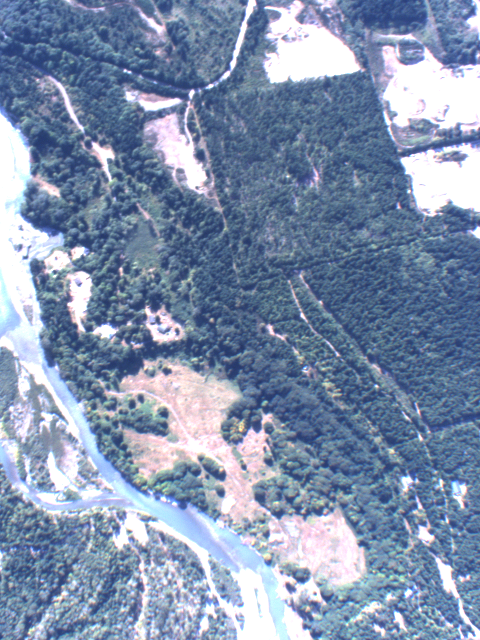

In [134]:
rgb_images = []
for x in range(num_images):
  image_data = im.fromarray(raw_images[:,:,x])
  rgb_images.append(image_data)
  image_data.save(f"../out/airborne_{x+1}.png")

display(rgb_images[10])

In [7]:
raw_ir_images = airborne_data[airborne_keys[4]]
print(type(raw_ir_images))
print(raw_ir_images.shape)

<class 'numpy.ndarray'>
(480, 640, 25)


Hmm... for some reason these images are sideways compared to the RGB ones. Also, pillow has trouble with this grayscale format so we are going to have to save images with matplotlib.

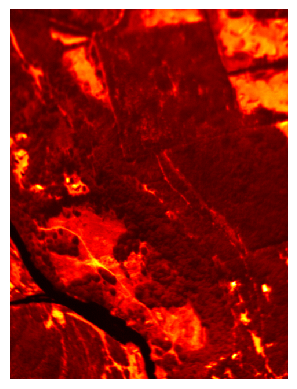

In [135]:
ir_images = []
for x in range(num_images):
  ir_image = np.rot90(raw_ir_images[:,:,x], -1, (0, 1))
  ir_images.append(ir_image)
  plt.imsave(f"../out/airborne_ir_{x+1}.png", ir_image, format="png", cmap="hot")

plt.imshow(ir_images[10], interpolation="none", cmap="hot")
plt.axis('off')
plt.show() # saved images won't look quite like this, as they won't have the white padding

## Stitching

Let's do a quick test to figure out how we will stitch and align our RGB images before we perform the operation on the entire dataset. Since the misalignment factor is constant throughout the dataset (the IR and RGB cameras were on the same plane, just at different angles) the way the first RGB and IR images misalign will be identical to the way the hundreth do.

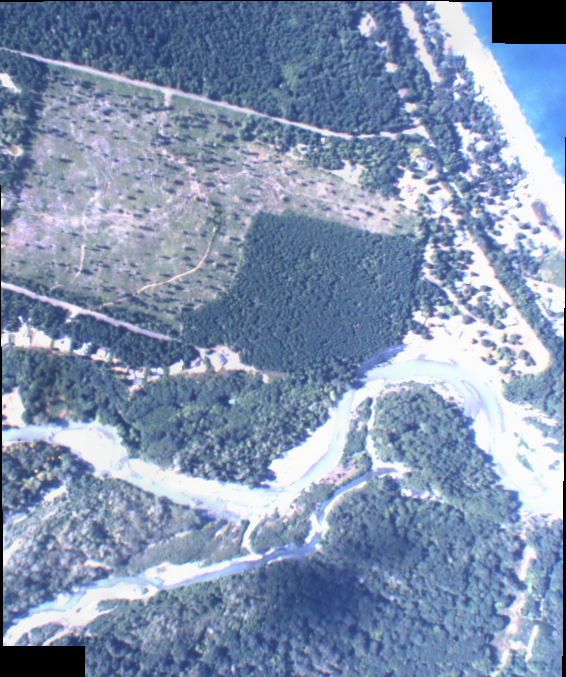

In [149]:
for x in range(num_images - 1):
	paths = [f"../out/airborne_{x+1}.png", f"../out/airborne_{x+2}.png"]
	images = []

	for path in paths:
		image = cv2.imread(path)
		images.append(image)

	stitcher = cv2.Stitcher_create()
	(status, stitched) = stitcher.stitch(images)

	# status 0 indicates success
	if status == 0:
		cv2.imwrite(f"../out/stitch_{x+1}.png", stitched)
	else:
		print(f"stitching failed with status {status} for images {x+1} <-> {x+2}")

im.open('../out/stitch_1.png')

Eyeballing it, here we can see that the 2nd infrared image aligns with the first and second RGB images. Given that the offset between IR and RGB images is constant (they were attached to the same plane, just at different angles), this means for any IR image `x` we match it with RGB images `x` and `x - 1`. This means we can match every IR image fully with the exception of the first IR image.

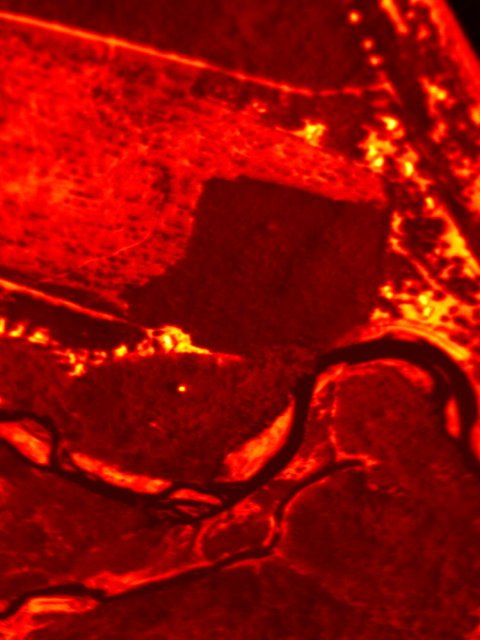

In [13]:
im.open("../out/airborne_ir_2.png")

## Matching

Now, we have to figure out what kind of descriptors we are going to use to figure out the alignment of the IR and RGB images. For a dataset where it is not as immediately obvious which images overlap with which and eyeballing it isn't going to cut it, the application of keypoints and descriptors could be used to match the images, but we will only be using them to figure out how to crop the stitched RGB images.

In [155]:
imrgb = cv2.imread('../out/stitch_1.png')[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
imir = cv2.imread('../out/airborne_ir_2.png', cv2.IMREAD_GRAYSCALE)

7066 RGB keypoints, 403 IR keypoints
279 matches found


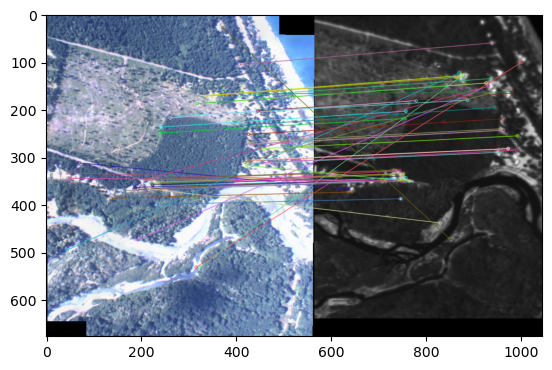

In [170]:
# Initiate BRISK detector
brisk = cv2.BRISK_create()

# find the keypoints and descriptors with BRISK, no mask
kp1, des1 = brisk.detectAndCompute(imrgb, None)
kp2, des2 = brisk.detectAndCompute(imir, None)
print(f"{len(kp1)} RGB keypoints, {len(kp2)} IR keypoints")

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)
print(len(matches), "matches found")

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

vis = cv2.drawMatches(imrgb, kp1, imir, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

It seems ORB descriptors don't do a half bad job, however BRISK descriptors seem to very slightly outperform them here. This makes sense as BRISK has lower variance in response to photometric changes like illumination compared to ORB, which excels at geometric changes. According to [this](https://arxiv.org/ftp/arxiv/papers/2012/2012.04135.pdf) paper, KAZE and AKAZE should outperform BRISK for photometric changes.

2300 RGB keypoints, 385 IR keypoints
211 matches found


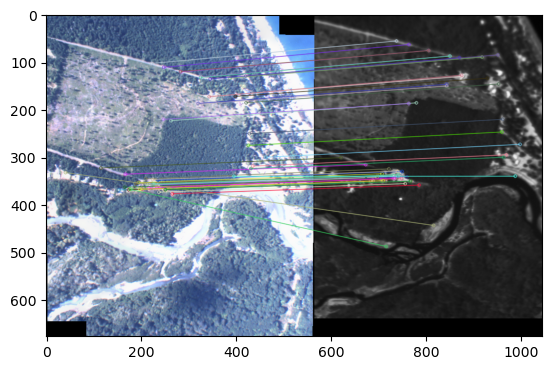

In [171]:
# Initiate AKAZE detector
akaze = cv2.AKAZE_create()

# find the keypoints and descriptors with BRISK
kp1, des1 = akaze.detectAndCompute(imrgb, None)
kp2, des2 = akaze.detectAndCompute(imir, None)
print(f"{len(kp1)} RGB keypoints, {len(kp2)} IR keypoints")

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)
print(len(matches), "matches found")

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

vis = cv2.drawMatches(imrgb, kp1, imir, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

From this simple test, this seems to be the case, with AKAZE only having 2 erroneous matches in the top 50 best matches, compared to BRISK's 8 erroneous matches.

## Mapping

The way `BFMatcher` works is that it returns to us a list of `cv2.DMatch` objects. Each of these objects has a `queryIdx` and `trainIdx` attribute. These correspond to the index in kp1 and kp2 which the match represents, respectively. Therefore we can obtain the image coordinates of the matches with the following code.

In [172]:
rgb_coords = []
ir_coords = []

for match in matches:
  rgb_kp_index = match.queryIdx
  ir_kp_index = match.trainIdx

  rgb_coords.append(kp1[rgb_kp_index].pt)
  ir_coords.append(kp2[ir_kp_index].pt)

Recall our images are 640x480, lets take a look what our points look like by ploting the coordinates for the first 15 matches. It should match the matches we have up above in the previous step.

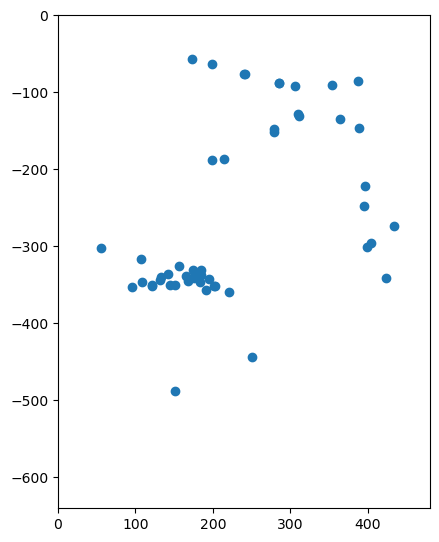

In [174]:
x_val = [pt[0] for pt in ir_coords[:50]]
y_val = [-pt[1] for pt in ir_coords[:50]] # negative because img coords start 0,0 at the top left with +y going down

plt.figure(figsize=(4.8, 6.4))
plt.scatter(x_val, y_val)
plt.xlim([0, 480])
plt.ylim([-640, 0])
plt.show()

Great, that seems to match. We will use the relative positions of these coordinates in the RGB image and their corresponding matched coordinates in the IR image to figure out how to map the bounds of the IR image onto the RGB image. Doing this on a per image basis ensures that varying levels of misalignment throughout the dataset don't matter, since we realign each image based on its own matches.

If we have two points in the RGB image and two in the IR, we have some distances `dx_ir` and `dx_rgb` that seperate the IR points and RGB points along the x axis in their respective coordinate spaces. Therefore, for any two pairs of points, we can estimate the size of 1 pixel in the IR image's coordinate space mapped to the RGB image's coordinate space to be `(x_rgb / x_ir)`. 

In [126]:
def findPixelRatio(rgb_coords, ir_coords):
  assert len(rgb_coords) == len(ir_coords)
  
  x_ratios = []
  y_ratios = []

  i = 0
  while i + 1 < len(rgb_coords):
    dx_rgb = abs(rgb_coords[i][0] - rgb_coords[i + 1][0])
    dx_ir = abs(ir_coords[i][0] - ir_coords[i + 1][0])

    dy_rgb = abs(rgb_coords[i][1] - rgb_coords[i + 1][1])
    dy_ir = abs(ir_coords[i][1] - ir_coords[i + 1][1])

    x_ratios.append(dx_rgb / dx_ir)
    y_ratios.append(dy_rgb / dy_ir)

    i += 2

  weight = np.divide(1, list(range(1, len(x_ratios) + 1)))

  # I want to somehow weight by the distance, but this level of fall-off
  # seems a bit extreme. Also I can't just multiply them...
  
  # print(np.multiply(x_ratios, weight))
  # print(np.multiply(y_ratios, weight))

  return (
    np.median(x_ratios),
    np.median(y_ratios),
  )

Great, so we have pixel size ratio `(x_rgb / x_ir)`. How do we map `(x0, y0)` in the IR image to the RGB image though? Once we have our pixel size ratio estimated as best as we can, we take some point `(x_ir, y_ir)` in the IR image and its counterpart `(x_rgb, y_rgb)` in the RGB image. The estimated origin of the IR image in RGB coords based on this pair of points should be `x_rgb - (ratio * x_ir)` and similarly for y.

As for where the `(x_max, y_max)` point of the IR image maps to in the RGB image's coordinate space, once we have estimated our origin's mapping, we can use our ratio to calculate the IR image's dimensions in the RGB image's coordinate space and add these values to the mapped origin point.

In [127]:
def findImageBounds(rgb_dim, ir_dim, x_ratio, y_ratio):
  x_zeros = []
  y_zeros = []

  x_maxes = []
  y_maxes = []

  i = 0
  while i + 1 < len(rgb_coords):
    x_zeros.append(rgb_coords[i][0] - (x_ratio * ir_coords[i][0]))
    y_zeros.append(rgb_coords[i][1] - (y_ratio * ir_coords[i][1]))
    
    # x_maxes.append(rgb_coords[i][0] + (x_ratio * (ir_dim[1] - ir_coords[i][0])))
    # y_maxes.append(rgb_coords[i][1] + (y_ratio * (ir_dim[0] - ir_coords[i][1])))

    i += 2

  x_min = round(np.median(x_zeros))
  y_min = round(np.median(y_zeros))
  # round(np.median(x_maxes))
  # round(np.median(y_maxes))

  return (
    x_min,
    y_min,
    round(x_min + (x_ratio * ir_dim[1])),
    round(y_min + (y_ratio * ir_dim[0])),
  )

Now, its time for putting it all together.

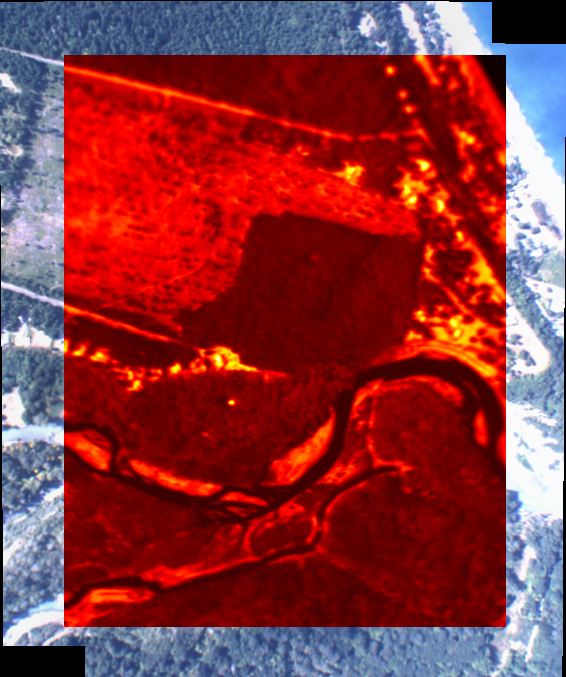

In [183]:
for x in range(num_images - 1):
  imrgb = cv2.imread(f"../out/stitch_{x+1}.png")[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
  imir = cv2.imread(f"../out/airborne_ir_{x+2}.png", cv2.IMREAD_GRAYSCALE)

  # Initiate AKAZE detector
  akaze = cv2.AKAZE_create()

  # find the keypoints and descriptors with BRISK
  kp1, des1 = akaze.detectAndCompute(imrgb, None)
  kp2, des2 = akaze.detectAndCompute(imir, None)

  # create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  # Match descriptors
  matches = bf.match(des1, des2)

  # Sort them in the order of their distance
  matches = sorted(matches, key = lambda x:x.distance)

  # Compile our coordinates
  rgb_coords = []
  ir_coords = []

  for match in matches[:50]:
    rgb_kp_index = match.queryIdx
    ir_kp_index = match.trainIdx

    rgb_coords.append(kp1[rgb_kp_index].pt)
    ir_coords.append(kp2[ir_kp_index].pt)

  # Find our image bounds
  ratios = findPixelRatio(rgb_coords, ir_coords)
  bounds = findImageBounds(imrgb.shape[0:2], imir.shape, ratios[0], ratios[1])

  imrgb = im.open(f"../out/stitch_{x+1}.png", "r")
  imir = im.open(f"../out/airborne_ir_{x+2}.png", "r")

  # size must be (width, height) for resize
  size = (bounds[2] - bounds[0], bounds[3] - bounds[1])
  imir = imir.resize(size)

  imrgb.paste(imir, bounds)
  imrgb.save(f"../out/match_{x+1}.png")
  
im.open('../out/match_1.png')